1.数据定义

In [80]:
import os
import re
import distance
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
from sklearn import svm
from fuzzywuzzy import fuzz
from sklearn import metrics
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix

for dirname, _, filenames in os.walk('./dataset/quora-question-pairs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

./dataset/quora-question-pairs\mmp.png
./dataset/quora-question-pairs\sample_submission.csv
./dataset/quora-question-pairs\test.csv
./dataset/quora-question-pairs\test_dev.csv
./dataset/quora-question-pairs\train.csv
./dataset/quora-question-pairs\train_dev.csv
./dataset/quora-question-pairs\train_dev_beta.csv


In [81]:
df_train =  pd.read_csv('./dataset/quora-question-pairs/train.csv')
print("Train Data Imported!")
df_train.shape

Train Data Imported!


(404290, 6)

2. 检查数据是否平衡

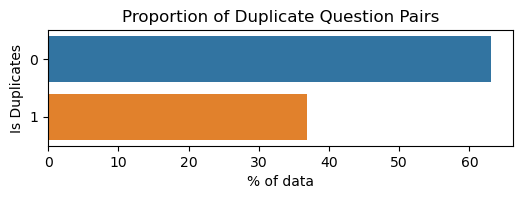

In [82]:
fig= plt.figure(figsize=(6,1.5))
sns.barplot(x=100*df_train['is_duplicate'].value_counts()/len(df_train),
            y=(100*df_train['is_duplicate'].value_counts()/len(df_train)).index,orient='h',).set(ylabel="Is Duplicates",xlabel="% of data",title="Proportion of Duplicate Question Pairs")
plt.show()

3. 检查是否有缺失值

In [83]:
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [84]:
ques2_list = df_train.loc[df_train['question1'].isnull(),'question2'].values
ques1_list = df_train.loc[df_train['question2'].isnull(),'question1'].values

display(df_train[df_train['question1'].isin(ques1_list)])
display(df_train.loc[df_train['qid2']==174364,:])

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
263095  263095  174363  239239    How can I develop android app?   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
263095  What is the best way of creating Android apps?...             0

id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0

In [85]:
display(df_train[df_train['question2'].isin(ques2_list)])
display(df_train.loc[df_train['qid1']==493340,:])

id    qid1    qid2 question1  \
363362  363362  493340  493341       NaN   

                                                question2  is_duplicate  
363362  My Chinese name is Haichao Yu. What English na...             0

id    qid1    qid2 question1  \
363362  363362  493340  493341       NaN   

                                                question2  is_duplicate  
363362  My Chinese name is Haichao Yu. What English na...             0

删除3个缺失的问题对

In [86]:
df = df_train.loc[~df_train.isnull().any(axis=1),:].copy()
print("Any Rows with Missing Data: ",(df.isna().sum()>0).any())
df['question1'] = df.loc[:,'question1'].apply(lambda x: str(x).strip())
df['question2'] = df.loc[:,'question2'].apply(lambda x: str(x).strip())

Any Rows with Missing Data:  False


4. 检查整个语料库中唯一问题和重复问题的数量

In [87]:
questions_list = pd.concat([df['question1'] , df['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  425464
Number of Questions which are repeated:  111873
Total number of unique questions in dataset:  537337


5. 重复问题的分布

In [88]:
rep_ques = questions_list.value_counts()[questions_list.value_counts()>1]
rep_ques

What are the best ways to lose weight?                                                    161
How can you look at someone's private Instagram account without following them?           120
How can I lose weight quickly?                                                            111
What's the easiest way to make money online?                                               88
Can you see who views your Instagram?                                                      79
                                                                                         ... 
How do I get girls to see me sexually?                                                      2
Why doesn't IndiGo airlines have a loyalty/frequent flyer program like other airlines?      2
How do I calculate resistance?                                                              2
Can we use non Tata sky dish antenna for Tata Sky set top box?                              2
Is cat worth a 1 year drop?                                 

Maximum number of times a single question is repeated:  161



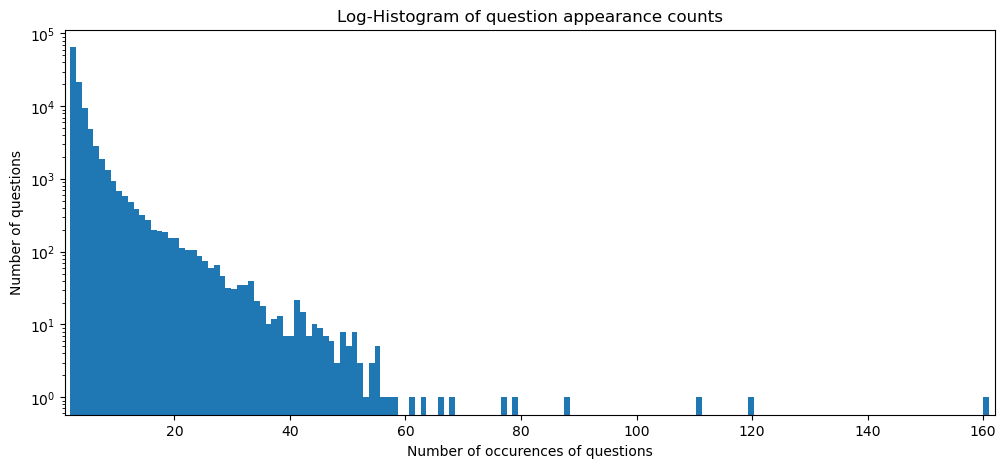

In [89]:
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(20, 3.5))
plt.hist(rep_ques, bins=160)
plt.yscale('log')

plt.xlim((1,162))
plt.title('Log-Histogram of question appearance counts')
plt.xlabel("Number of occurences of questions")
plt.ylabel("Number of questions")
print('Maximum number of times a single question is repeated:  {}\n'.format(max(rep_ques)))
plt.show()

In [90]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
math_q = [q  for q in document_corpus if '[math]' in q]

print("Percentage of Questions with '?' (not necessarily ending with): {0:.3f} %".format(100*len([q  for q in document_corpus if '?' in q])/len(document_corpus)))
print("Percentage of Questions not having '?': {0:.3f} %".format(100*len([q  for q in document_corpus if '?' not in q])/len(document_corpus)))
print("Number of Math based questions:  {0:3f} %".format(100*len(math_q)/len(document_corpus)))
print("Questions with multiple parts: {0:.3f} %".format(100*len([ q for q in document_corpus if len(q.split('?'))>2 ])/len(document_corpus) ))
print("\nExamples of Questions with subparts : ",[ q for q in document_corpus if len(q.split('?'))>2 ][0:2]) 
print("\nPersonal or Opinion-based questions: {0:.3f} %".format(100*len([q for q in document_corpus if ('you' in q) or (' i ' in q) ])/len(document_corpus)))
print("\nSome Personal Or Opinion-based questions: ", [q for q in document_corpus if 'you' in q][:2])

Percentage of Questions with '?' (not necessarily ending with): 99.864 %
Percentage of Questions not having '?': 0.136 %
Number of Math based questions:  0.138647 %
Questions with multiple parts: 5.542 %

Examples of Questions with subparts :  ['What health problems can a marine engineer have during the overseas sailing? What can be the worst?', 'What are the capital requirements for KK and GK companies in Japan? (These have changed recently)?']

Personal or Opinion-based questions: 12.038 %

Some Personal Or Opinion-based questions:  ['What is the most soul crushing experience you have ever had?', 'How do you know if your guinea pig is feeling hot?']


6. 文本预处理

In [91]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [92]:
%%time
import pickle
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
df = pickle.load(open('df.pkl', 'rb'))
print("Train Data Text Pre-processing Done!")

Train Data Text Pre-processing Done!
CPU times: total: 78.1 ms
Wall time: 200 ms


In [93]:
# import pickle

# with open('df.pkl', 'wb') as f:
#     pickle.dump(df, f)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


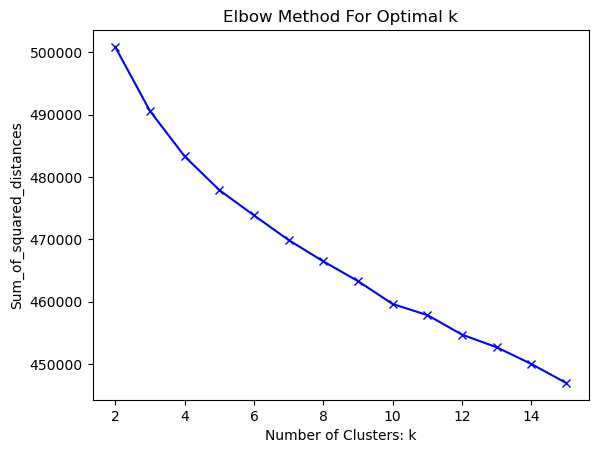

Finding Optima*l Cluster Number Done!
CPU times: total: 11.8 s
Wall time: 15.2 s


<Figure size 640x480 with 0 Axes>

In [94]:
%%time
import pickle
from sklearnex import patch_sklearn
patch_sklearn()


# 获取所有问题并去重
document_corpus = list( set(list(df['question1']) + list(df['question2'])) )

# 初始化 TfidfVectorizer，并将文本转换为 Tfidf 矩阵
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(document_corpus)

# 初始化 Sum_of_squared_distances 数组，用于记录不同聚类数对应的误差平方和（SSE）
Sum_of_squared_distances = []

# 遍历不同的聚类数
for k in tqdm(range(2,16)):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)

Sum_of_squared_distances = pickle.load(open("Sum_of_squared_distances.pkl", "rb"))

# 绘制 Elbow 图
plt.plot(range(2,16), Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters: k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 输出找到最佳聚类数的提示信息，并保存图片
print("Finding Optima*l Cluster Number Done!")
plt.savefig("cluster_analysis.png")

In [95]:
# import pickle

# # 保存聚类模型
# with open('cluster_model.pkl', 'wb') as f:
#     pickle.dump(Sum_of_squared_distances, f)

在这里，我们看到，当聚类数=5时，有一个轻微的下降，之后，平方距离之和呈线性下降。因此，我们将最佳群集数定为5，并将群集映射到相应的问题上。

In [96]:
%%time

# 将问题内容进行合并去重，得到文本语料库
document_corpus = list(set(list(df['question1']) + list(df['question2'])))

# 创建一个数据框存储文本和对应的聚类标签
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})

# 将文本转化为TF-IDF特征向量，并取前1000个特征，包括单个单词和两个单词的组合
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(questions_cluster['questions'].values)

# 对特征向量进行标准化处理，将其缩放到均值为0，标准差为1的范围
sc_x = StandardScaler()
std_x = sc_x.fit_transform(x.toarray())
print("standardised")



questions_cluster = pickle.load(open("questions_cluster.pkl", "rb"))

standardised
CPU times: total: 22.3 s
Wall time: 29.8 s


In [97]:
from sklearn.manifold import TSNE
import seaborn as sns

# 使用t-SNE算法进行聚类，并将结果在二维平面上可视化
# 遍历多个不同的聚类数值（4到11），每个聚类结果在二维平面上可视化
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,17))
i=1

# Loop over different perplexity values for t-SNE algorithm
for p in tqdm(range(4,12)):
    # Use t-SNE algorithm to transform feature vectors into 2D embeddings
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne_vecs = tsne.fit_transform(std_x)
    x0 = tsne_vecs[:, 0]
    x1 = tsne_vecs[:, 1]
    
    # Plot the 2D embeddings with different colors for different clusters
    plt.subplot(2,4,p-3)
    plt.title("TF-IDF + t-SNE Questions clustering, perplexity="+str(p), fontdict={"fontsize": 12})
    plt.xlabel("X1", fontdict={"fontsize": 12})
    plt.ylabel("X0", fontdict={"fontsize": 12})
    sns.scatterplot(data=questions_cluster, x=x1, y=x0, hue=km.labels_, palette="viridis")

100%|██████████| 8/8 [04:19<00:00, 32.50s/it]


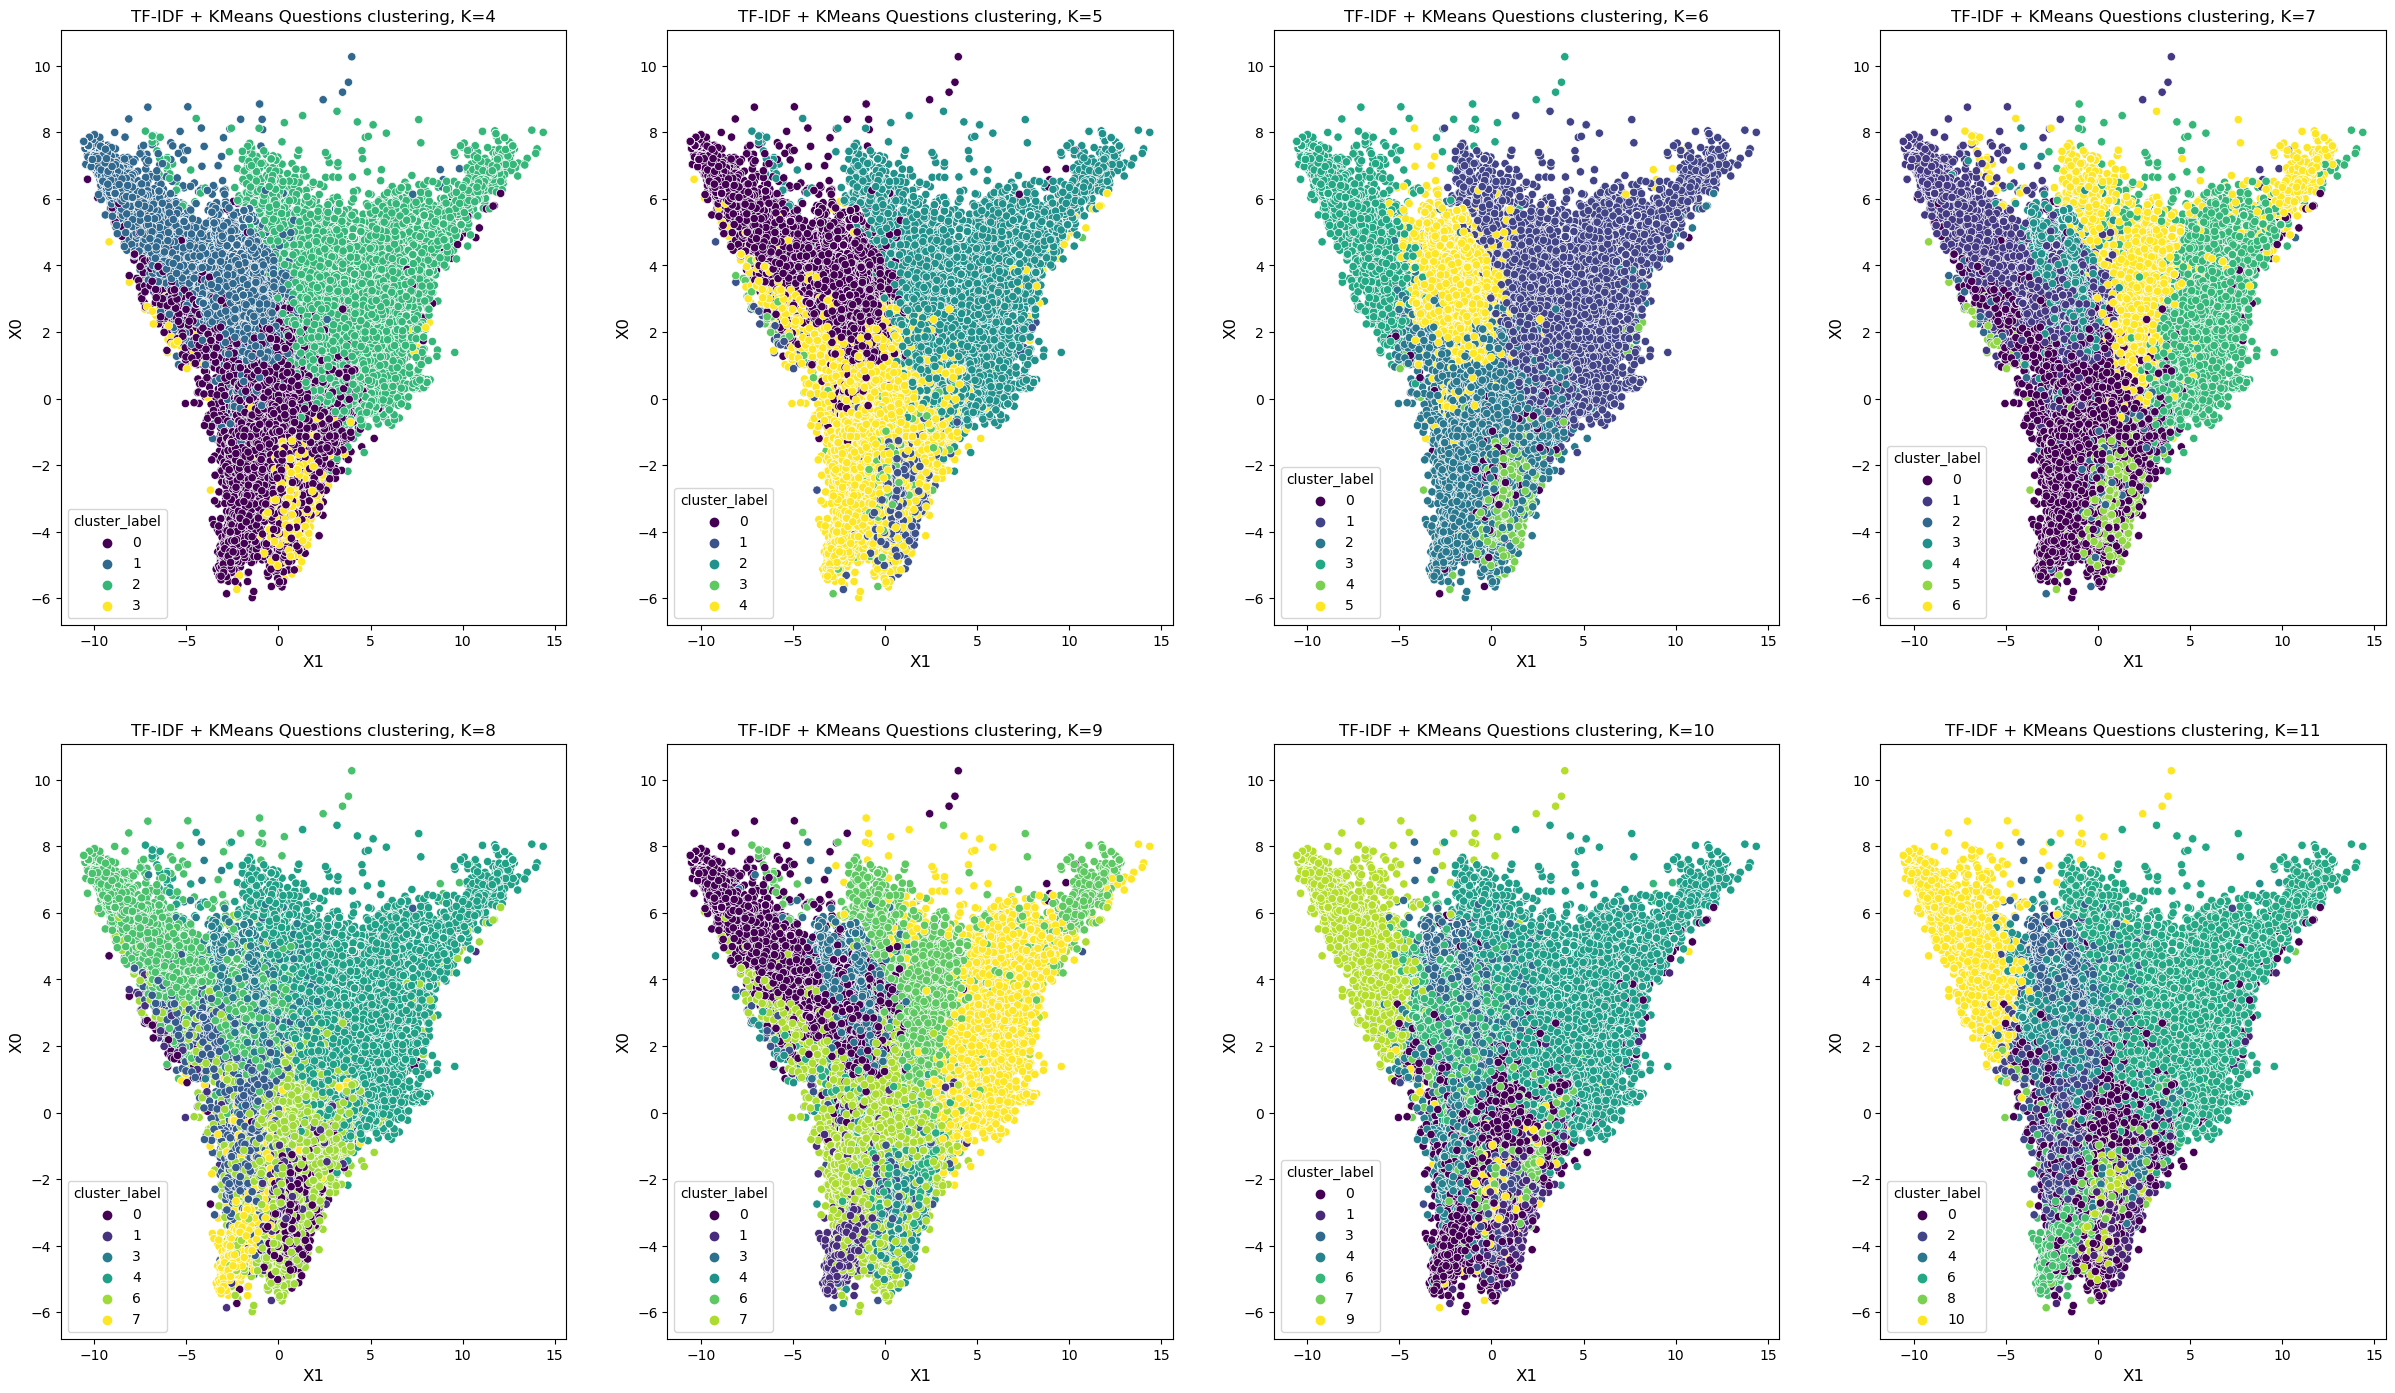

In [100]:
# 使用KMeans算法进行聚类，并将结果在二维平面上可视化
# 遍历多个不同的聚类数值（4到11），每个聚类结果在二维平面上可视化
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,17))
i=1

for k in tqdm(range(4,12)): # tqdm是一个进度条库，可以用来显示循环的进度
    
    # 创建KMeans模型，并训练模型
    km = KMeans(n_clusters=k, max_iter=500, n_init=20)
    km = km.fit(x)

    # 将每个问题的聚类标签存储在数据框中
    questions_cluster['cluster_label'] = km.labels_

    # 使用PCA算法将特征向量降维到二维平面上
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(std_x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    questions_cluster['x0'] = x0
    questions_cluster['x1'] = x1

    # 在一个2x4的子图中绘制散点图
    plt.subplot(2,4,i)
    plt.title("TF-IDF + KMeans Questions clustering, K="+str(k), fontdict={"fontsize": 12})
    plt.xlabel("X1", fontdict={"fontsize": 12})
    plt.ylabel("X0", fontdict={"fontsize": 12})
    sns.scatterplot(data=questions_cluster, x='x1', y='x0', hue='cluster_label', palette="viridis")
    i+=1


# 显示图像
plt.show()

In [101]:
# import pickle

# # 保存聚类模型
# with open('questions_cluster.pkl', 'wb') as f:
#     pickle.dump(questions_cluster, f)

7. 不同问题群的词云

100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


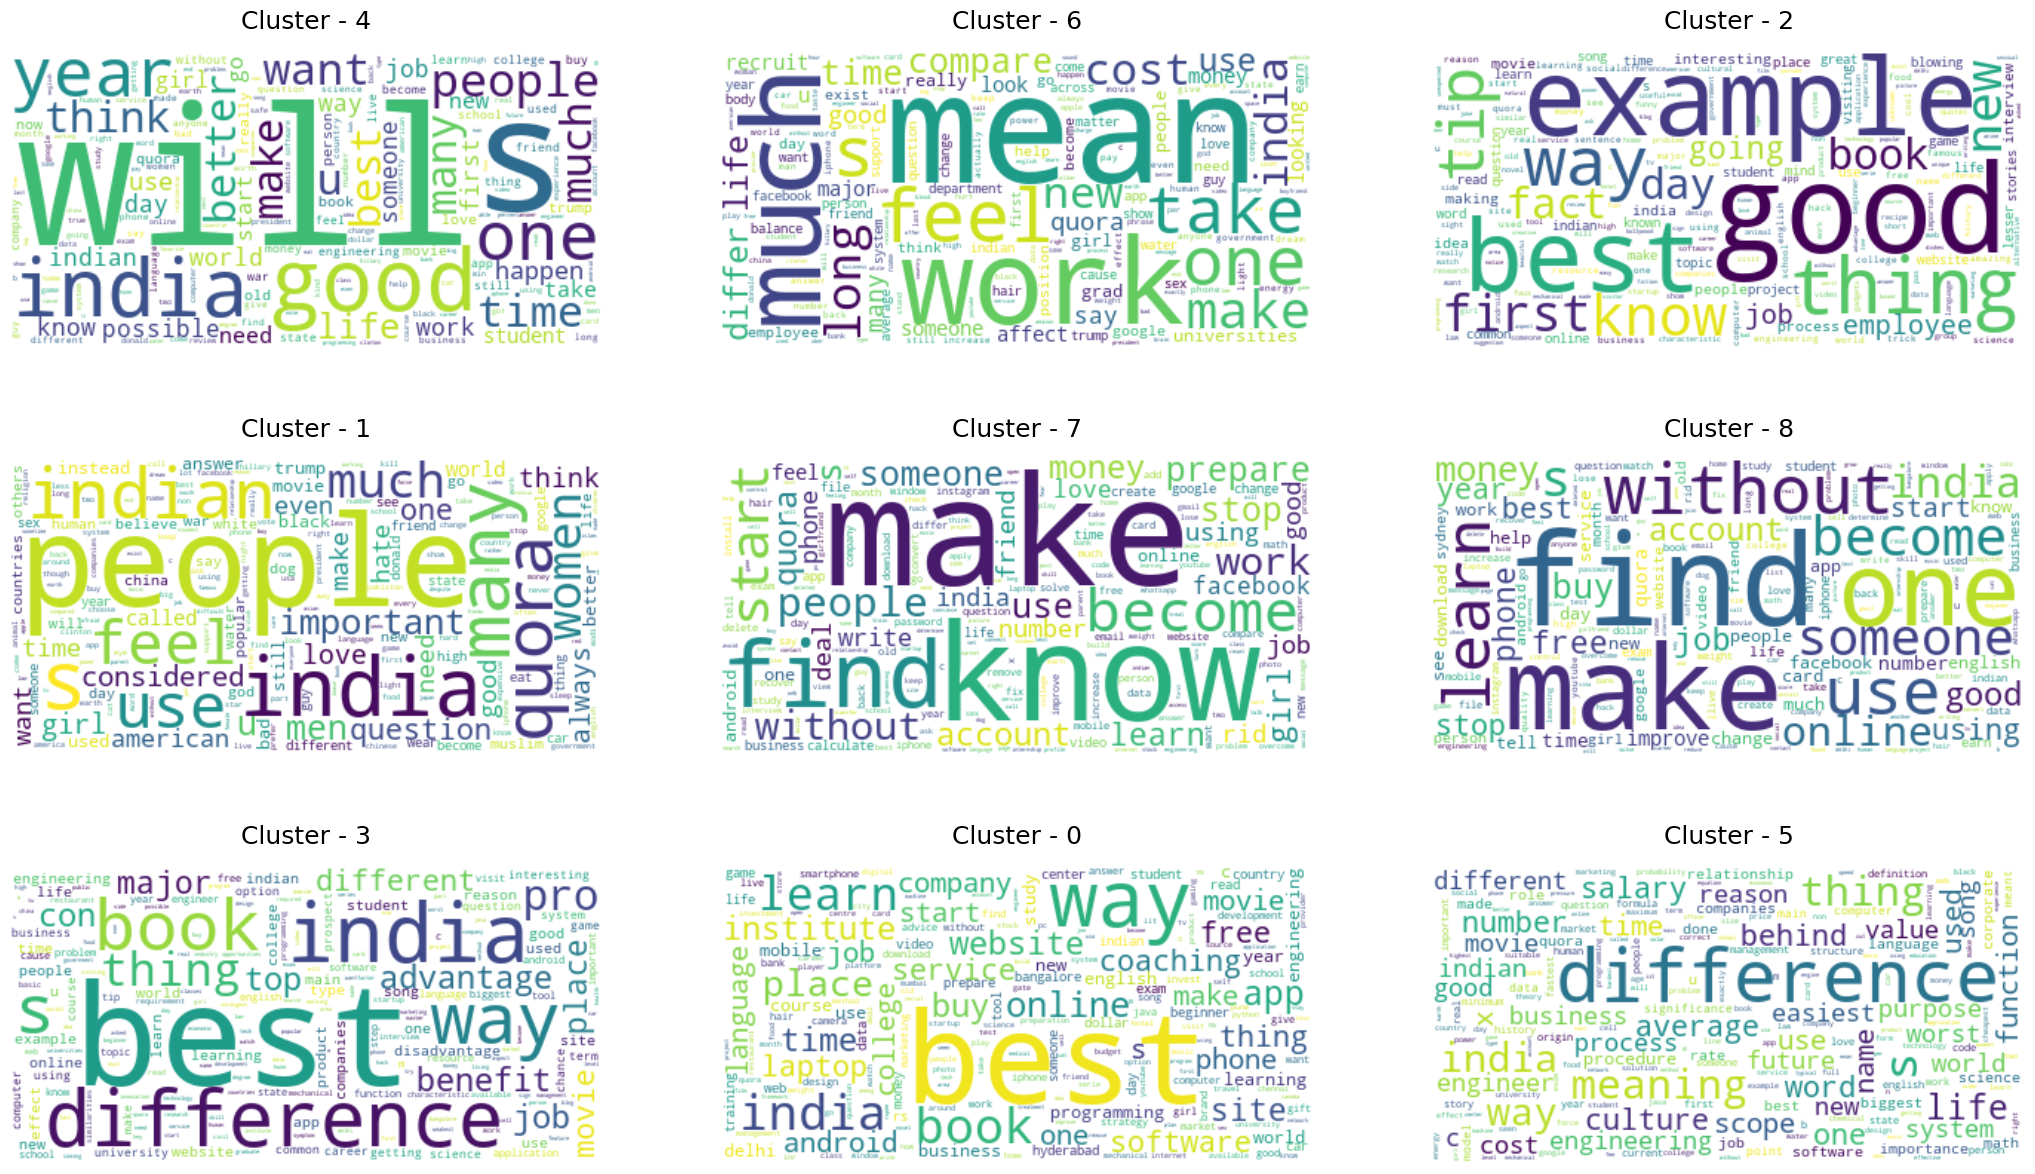

CPU times: total: 1min
Wall time: 1min 8s


In [102]:
%%time

# 获取问题的语料库
document_corpus = list(set(list(df['question1']) + list(df['question2'])))

# 创建数据帧用于存储问题和聚类标签
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})

# 对语料库进行特征提取，生成文档-词条矩阵
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))
x = vectorizer.fit_transform(questions_cluster['questions'].values)

# 对文档进行K-Means聚类
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
questions_cluster['cluster_label'] = km.labels_


# 创建画布用于展示聚类结果的词云图
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(26,15))

# 对每个聚类进行处理
i=1
for cluster in tqdm(questions_cluster['cluster_label'].unique()):
    # 从当前聚类中获取所有问题，将其转化为字符串并生成词云
    questions = " ".join(questions_cluster[questions_cluster['cluster_label']==cluster]['questions'].values)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(questions)
    
    # 从当前聚类中获取所有问题，将其转化为字符串并生成词云
    plt.subplot(3,3,i)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title("Cluster - "+str(cluster), fontsize=18,pad=17)
    plt.axis("off")
    i+=1
    
# 显示画布
plt.show()

In [103]:
len(['how' in q for q in questions_cluster.loc[questions_cluster['cluster_label']==1,['questions']].values]),

(42391,)

In [104]:
print(len(['what' in q for q in questions_cluster.loc[questions_cluster['cluster_label']==2,['questions']].values]))
questions_cluster.loc[questions_cluster['cluster_label']==2,['questions']].values[10:],questions_cluster.loc[questions_cluster['cluster_label']==3,['questions']].values[10:] 

21515


(array([['what are black codes  what are some examples'],
        ['which are some of the best unbiased news sources'],
        ['what are some symptoms of a bad starter solenoid'],
        ...,
        ['what are some of the most annoying questions on quora that you wanted to answer'],
        ['motorcycle maintenance  what are some imperative steps to follow for honda unicorn s  or in that case any motorbike s  maintainance'],
        ['what are some examples of unique skills that are worthwhile to posses']],
       dtype=object),
 array([['what are the best black anime characters'],
        ['what are the image recognition applications for brands today'],
        ['which are the best tv series currently showing in the u s'],
        ...,
        ['what are the best ways of using quora credits'],
        ['what are the advantages of dedicated server hosting'],
        ['what are the healthiest snacks you can find in a town small city in india']],
       dtype=object))

In [105]:
questions_cluster.loc[questions_cluster['cluster_label']==4,['questions']].values[10:],questions_cluster.loc[questions_cluster['cluster_label']==5,['questions']].values[10:] 

(array([['what is your review of uttar pradesh  india'],
        ['what is a good book about design'],
        ['which ebook reader is a better value for money buy  kindle voyage or oasis'],
        ...,
        ['who is the most selfish tv or movie character ever'],
        ['what should i gift my dad under a budget of 30k to 32k rs'],
        ['what do you think about this argument against the existence of god']],
       dtype=object),
 array([['what is primary coil in transformers'],
        ['what is the difference between a masters in computer science and information technology'],
        ['what is the last president currently doing'],
        ...,
        ['what is flash point'],
        ['what is the differentiation of x x  math  with respect to x  math'],
        ['what is the difference between nirmal baba and companies ripping off people with their misleading ads']],
       dtype=object))

In [106]:
# 将问题所属的聚类标签加入到原始数据集df中，并删除不必要的列
# 然后重命名标签列
df = pd.merge( left=pd.merge(left=df, right=questions_cluster, left_on="question1", right_on="questions"), right=questions_cluster , left_on="question2", right_on="questions")
df.drop(["questions_x","questions_y"], axis=1, inplace=True)
df.rename(columns={'cluster_label_x':'q1_cluster','cluster_label_y':'q2_cluster'}, inplace=True)

# 打印数据集的前4个样本
print("Train Questions cluster labelling Done!")
df.head(4)

Train Questions cluster labelling Done!


id  qid1    qid2                                          question1  \
0       0     1       2  what is the step by step guide to invest in sh...   
1       1     3       4  what is the story of kohinoor  koh i noor  dia...   
2  184732     3  282170  what is the story of kohinoor  koh i noor  dia...   
3  263614     3  380197  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate  \
0  what is the step by step guide to invest in sh...             0   
1  what would happen if the indian government sto...             0   
2               is it possible to melt down diamonds             0   
3  what are some interesting facts about kohinoor...             0   

   q1_cluster  q2_cluster  
0           5           5  
1           5           4  
2           5           4  
3           5           2

8. 基本特征提取

In [107]:
%%time
df = pd.merge( pd.merge(df,pd.DataFrame({'qid1':df['qid1'].value_counts().index.values,
                                         'freq_qid1':df['qid1'].value_counts().values}), on='qid1',how="left"),pd.DataFrame({'qid2':df['qid2'].value_counts().index.values,
                                                                                                                             'freq_qid2':df['qid2'].value_counts().values}) ,on='qid2', how='left')
df['is_duplicate'] = df['is_duplicate'].apply(lambda x: "Yes" if x==1 else "No")
df.loc[:,['q1_length']] = df['question1'].apply(lambda x: len(x)).values
df.loc[:,['q2_length']] = df['question2'].apply(lambda x: len(x)).values
df['same_cluster'] = df[['q1_cluster','q2_cluster']].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)
df['q1_wordsCount'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_wordsCount'] = df['question2'].apply(lambda x: len(x.split(" ")))
df['common_wordsCount'] = df[['question1','question2']].apply(lambda x: len(set(x[0].split(" ")).intersection(set(x[1].split(" ")))) , axis=1 )
df['q1_freq+q2_freq'] = df['freq_qid1']+df['freq_qid2']
df['q1_freq-q2_freq'] = abs(df['freq_qid1']-df['freq_qid2'])
df['total_word_share'] = 2*df['common_wordsCount']/(df['q1_wordsCount']+df['q2_wordsCount'])
print("Train Data Basic Feature Engineering Done!")
df.head(2)

Train Data Basic Feature Engineering Done!
CPU times: total: 6.2 s
Wall time: 7.83 s


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           5   
1  what would happen if the indian government sto...           No           5   

   q2_cluster  freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  \
0           5          1          1         65         56             1   
1           4          4          1         50         87             0   

   q1_wordsCount  q2_wordsCount  common_wordsCount  q1_freq+q2_freq  \
0             14             12                 11                2   
1             12             17                  8                5   

   q1_freq-q2_freq  total_word_share  
0                0          0.846154  
1                3          0.551724

In [108]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_cluster', 'q2_cluster', 'freq_qid1', 'freq_qid2', 'q1_length',
       'q2_length', 'same_cluster', 'q1_wordsCount', 'q2_wordsCount',
       'common_wordsCount', 'q1_freq+q2_freq', 'q1_freq-q2_freq',
       'total_word_share'],
      dtype='object')

In [109]:
%%time
STOP_WORDS = stopwords.words("english")
epsilon = 0.001
       
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def advanced_featureExtract(q1,q2):
    
    q1_tokens = q1.split(" ")
    q2_tokens = q2.split(" ")
    
    q1_stopwords = [word for word in q1_tokens if word in STOP_WORDS]
    q2_stopwords = [word for word in q2_tokens if word in STOP_WORDS]
    
    q1_words = [word for word in q1_tokens if word not in STOP_WORDS]
    q2_words = [word for word in q2_tokens if word not in STOP_WORDS]
        
    common_words = list(set(q1_words).intersection(set(q2_words)))
    common_stopwords = list(set(q1_stopwords).intersection(set(q2_stopwords)))
    common_tokens = list(set(q1_tokens).intersection(set(q2_tokens)))
    
    com_words_count_min = len(common_words)/(epsilon + min(len(q2_words), len(q1_words)) )
    com_words_count_max = len(common_words)/(epsilon + max(len(q2_words), len(q1_words)) )
    
    com_stopwords_count_min = len(common_words)/(epsilon + min(len(q2_stopwords), len(q1_stopwords)) )
    com_stopwords_count_max = len(common_stopwords)/(epsilon + max(len(q2_stopwords), len(q1_stopwords)) )
    
    com_token_count_min = len(common_tokens)/(epsilon + min(len(q2_tokens), len(q1_tokens)) )
    com_token_count_max = len(common_tokens)/(epsilon + max(len(q2_tokens), len(q1_tokens)) )
    
    last_word_eq  = 1 if q2_tokens[-1] == q1_tokens[-1] else 0
    first_word_eq = 1 if q2_tokens[0]  == q1_tokens[0]  else 0
    
    abs_len_diff = abs(len(q2_tokens) - len(q1_tokens))
    mean_len = (len(q2_tokens) + len(q1_tokens))/2

    longest_substring_ratio = get_longest_substr_ratio(q1, q2)
    
    return com_words_count_min, com_words_count_max, com_stopwords_count_min,  com_stopwords_count_max, com_token_count_min, com_token_count_max,  last_word_eq, first_word_eq, abs_len_diff, mean_len, longest_substring_ratio
       
token_features = df.apply(lambda x: advanced_featureExtract(x["question1"], x["question2"]), axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))
df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
df["mean_len"]      = list(map(lambda x: x[9], token_features))
df["longest_substring_ratio"] = list(map(lambda x: x[10], token_features))
df = pickle.load(open("df2.pkl","rb"))
print("Train Data Advanced Feature Engg Done!")
df.head(2)

Train Data Advanced Feature Engg Done!
CPU times: total: 15.6 ms
Wall time: 194 ms


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           1   
1  what would happen if the indian government sto...           No           1   

   q2_cluster  freq_qid1  freq_qid2  ...   cwc_max   csc_min  csc_max  \
0           1          1          1  ...  0.714184  0.833194  0.85702   
1           5          4          1  ...  0.416632  0.999800  0.59988   

    ctc_min   ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.916590  0.785658             0              1             2      13.0   
1  0.666611  0.470561             0              1             5      14.5   

   longest_substring_ratio  
0                 0.982456  
1                 0.588235  

[2 rows x 30 columns]

In [110]:
# import pickle

# with open('df2.pkl', 'wb') as f:
#     pickle.dump(df, f)

9. 模糊文本相似性特征提取

In [111]:
%%time

# 使用fuzz库中的ratio()函数，对两个问题字符串进行模糊匹配，并计算匹配分数
df['fuzz_ratio']           = df[['question1','question2']].apply(lambda x: fuzz.ratio(x[0],x[1]),           axis=1)

# 使用fuzz库中的partial_ratio()函数，对两个问题字符串进行部分模糊匹配，并计算匹配分数
df['fuzz_partial_ratio']   = df[['question1','question2']].apply(lambda x: fuzz.partial_ratio(x[0],x[1]),   axis=1)

# 使用fuzz库中的token_sort_ratio()函数，对两个问题字符串进行单词排序后进行模糊匹配，并计算匹配分数
df['fuzz_token_sort_ratio']= df[['question1','question2']].apply(lambda x: fuzz.token_sort_ratio(x[0],x[1]),axis=1)

# 使用fuzz库中的token_set_ratio()函数，对两个问题字符串进行集合运算后进行模糊匹配，并计算匹配分数
df['fuzz_token_set_ratio'] = df[['question1','question2']].apply(lambda x: fuzz.token_set_ratio(x[0],x[1]), axis=1)

# 使用fuzz库中的WRatio()函数，对两个问题字符串进行模糊匹配，并根据单词权重进行计算匹配分数
df['fuzz_WRatio']          = df[['question1','question2']].apply(lambda x: fuzz.WRatio(x[0],x[1]),          axis=1)

df = pickle.load(open("df3.pkl","rb"))
print("Train Data Fuzzy Ratios done!")
df.head(2)

Train Data Fuzzy Ratios done!
CPU times: total: 109 ms
Wall time: 238 ms


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           1   
1  what would happen if the indian government sto...           No           1   

   q2_cluster  freq_qid1  freq_qid2  ...  last_word_eq  first_word_eq  \
0           1          1          1  ...             0              1   
1           5          4          1  ...             0              1   

   abs_len_diff  mean_len  longest_substring_ratio  fuzz_ratio  \
0             2      13.0                 0.982456          93   
1             5      14.5                 0.588235          66   

   fuzz_partial_ratio  fuzz_token_sort_ratio  fuzz_token_set_ratio  \
0                 100                     93                   100   
1                  74                     63                    86   

   fuzz_WRatio  
0           95  
1           86  

[2 rows x 35 columns]

In [112]:
# import pickle

# with open('df3.pkl', 'wb') as f:
#     pickle.dump(df, f)

10. 从TF-IDF文本向量中找到余弦相似性

In [113]:
%%time

# 将两个问题列合并为一个列表
document_corpus = list(df['question1'])+list(df['question2'])

# 计算tf-idf向量
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(document_corpus)

# 将所有问题分为两部分，分别用于计算向量
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
# 对于每一对问题，计算其余向量的点积
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

# # 将余弦相似度添加为新的列
df['cosine_similarity'] = ques_pair_vectors
df = pickle.load(open("df4.pkl","rb"))
print("Train Data cosine_similarity Done !")
df.head(2)

Train Data cosine_similarity Done !
CPU times: total: 125 ms
Wall time: 235 ms


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2 is_duplicate  q1_cluster  \
0  what is the step by step guide to invest in sh...           No           1   
1  what would happen if the indian government sto...           No           1   

   q2_cluster  freq_qid1  freq_qid2  ...  first_word_eq  abs_len_diff  \
0           1          1          1  ...              1             2   
1           5          4          1  ...              1             5   

   mean_len  longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
0      13.0                 0.982456          93                 100   
1      14.5                 0.588235          66                  74   

   fuzz_token_sort_ratio  fuzz_token_set_ratio  fuzz_WRatio  cosine_similarity  
0                     93                   100           95           0.978506  
1                     63                    86           86           0.749980  

[2 rows x 36 columns]

In [114]:
# import pickle

# with open('df4.pkl', 'wb') as f:
#     pickle.dump(df, f)

In [115]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_cluster', 'q2_cluster', 'freq_qid1', 'freq_qid2', 'q1_length',
       'q2_length', 'same_cluster', 'q1_wordsCount', 'q2_wordsCount',
       'common_wordsCount', 'q1_freq+q2_freq', 'q1_freq-q2_freq',
       'total_word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substring_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_WRatio', 'cosine_similarity'],
      dtype='object')

In [116]:
df.isna().sum()

id                         0
qid1                       0
qid2                       0
question1                  0
question2                  0
is_duplicate               0
q1_cluster                 0
q2_cluster                 0
freq_qid1                  0
freq_qid2                  0
q1_length                  0
q2_length                  0
same_cluster               0
q1_wordsCount              0
q2_wordsCount              0
common_wordsCount          0
q1_freq+q2_freq            0
q1_freq-q2_freq            0
total_word_share           0
cwc_min                    0
cwc_max                    0
csc_min                    0
csc_max                    0
ctc_min                    0
ctc_max                    0
last_word_eq               0
first_word_eq              0
abs_len_diff               0
mean_len                   0
longest_substring_ratio    0
fuzz_ratio                 0
fuzz_partial_ratio         0
fuzz_token_sort_ratio      0
fuzz_token_set_ratio       0
fuzz_WRatio   

11. 特征标准化

In [117]:
# 复制数据集
x= df.copy()

# 去除不需要的列
x.drop(['id','qid1','qid2','question1','question2','is_duplicate','q1_cluster', 'q2_cluster'], axis=1, inplace=True)

# 对数值特征进行标准化处理
# 在第0列插入一列值都为1的常数列
sc_x = StandardScaler()
x.insert(loc=0, column='x0', value=[1]*len(x))
x.iloc[:,1:-1] = sc_x.fit_transform(x.iloc[:,1:-1])

# 将目标变量转换为0/1二分类
y=df['is_duplicate'].apply(lambda x: 0 if x=="No" else 1)

# 输出数据集和目标变量的形状
x.shape, y.shape

((404287, 29), (404287,))

12.不同分类模型性能比较

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
# 设定 epsilon 的值
eps=0.001

# 计算模型的损失函数
def model_lg_loss(model, x_cv, y_cv):
    lg_loss=pd.DataFrame(model.predict_proba(x_cv), index=range(len(y_cv)))
    lg_loss['y_cv']=y_cv.values 
    return sum(lg_loss.apply(lambda x: -np.log(eps + x[int(x.values[-1])]) if int(x.values[-1])==1 else 0, axis=1).values)/len(y_cv)


  0%|          | 0/5 [00:00<?, ?it/s]

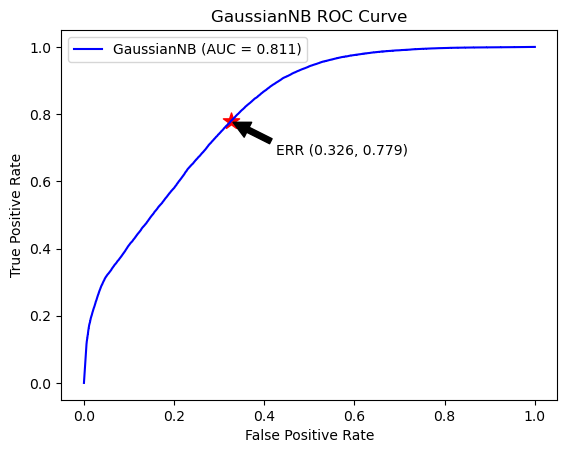

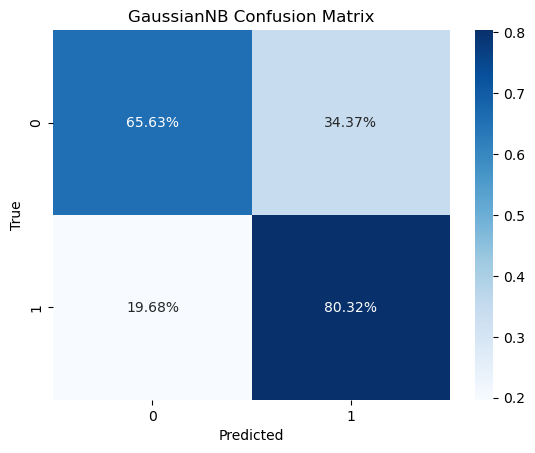

 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

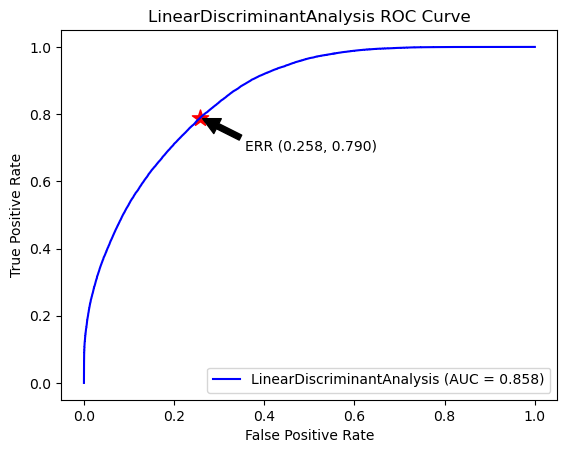

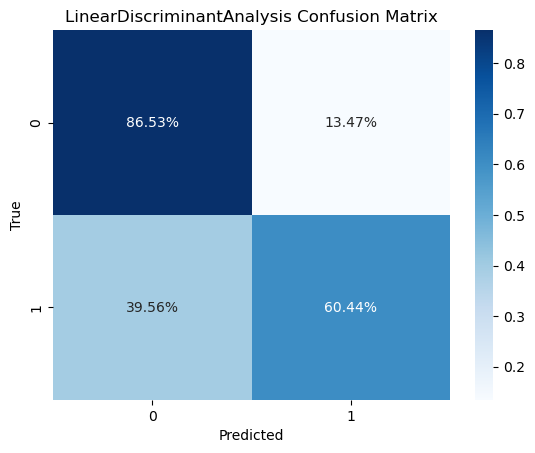

 40%|████      | 2/5 [00:03<00:04,  1.63s/it]

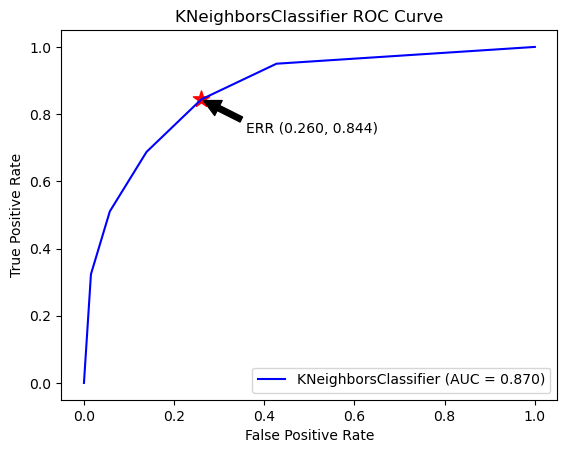

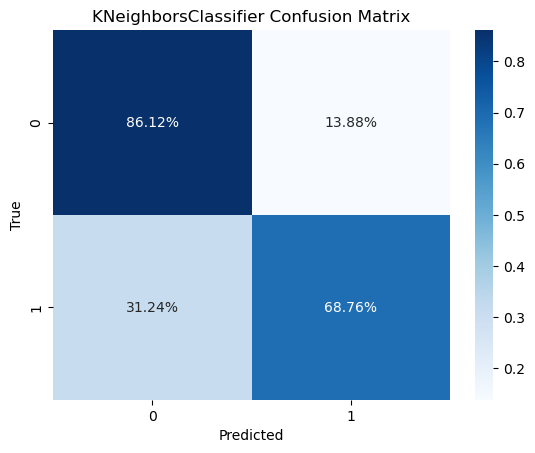

 60%|██████    | 3/5 [01:12<01:05, 32.51s/it]

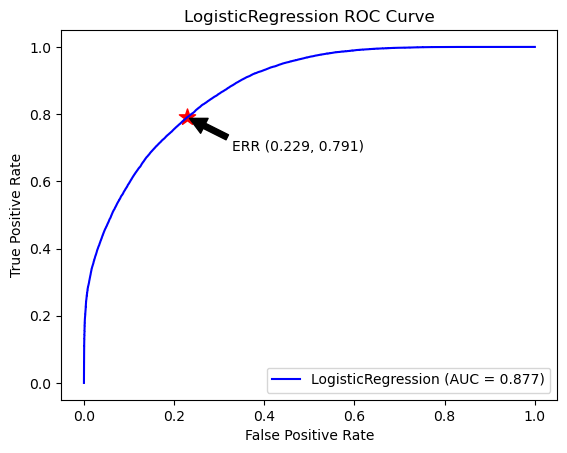

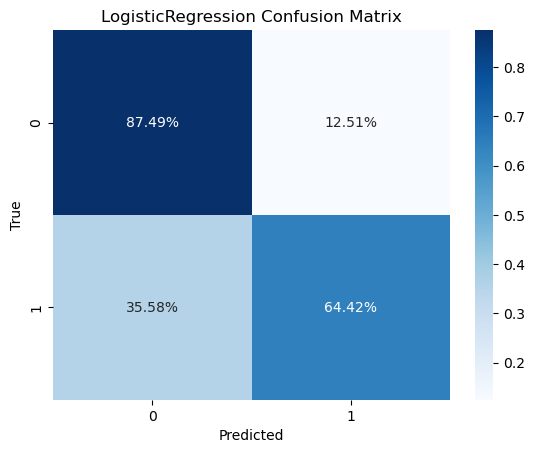

 80%|████████  | 4/5 [01:14<00:20, 20.21s/it]

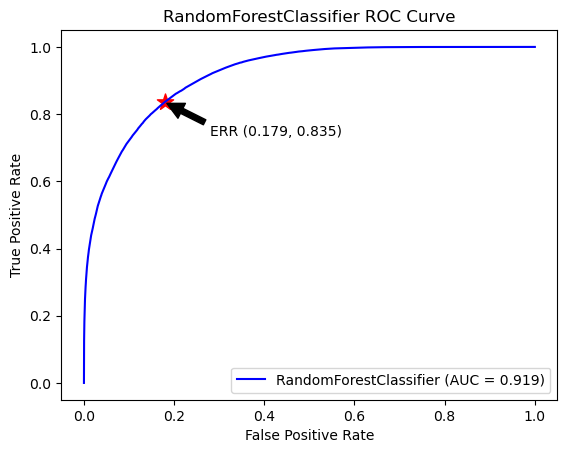

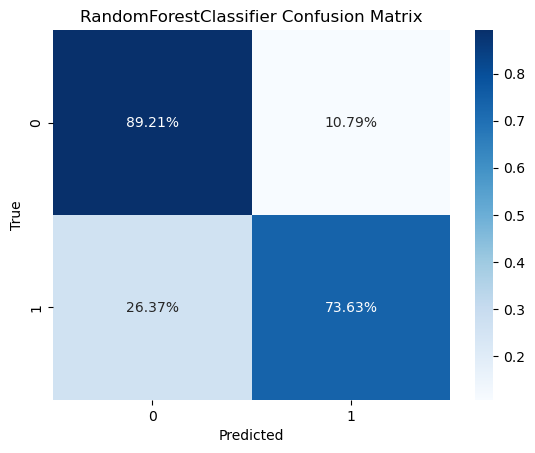

100%|██████████| 5/5 [01:36<00:00, 19.32s/it]

CPU times: total: 16min 48s
Wall time: 1min 42s


In [120]:
%%time

# 创建一个空的 DataFrame 用于存储模型比较结果
model_comparison = pd.DataFrame(columns=['model','logloss','overall-accuracy','TPR','TNR','FPR','FNR'])

# 划分训练集和验证集
train_x, x_cv, train_y, y_cv = train_test_split(    x,    y,    test_size=0.25,    random_state=0)

# 创建需要比较的模型列表
models=[GaussianNB(),                                                                                   # 朴素贝叶斯模型
        LinearDiscriminantAnalysis(),                                                                   # 线性判别分析模型
        KNeighborsClassifier(n_neighbors=5),                                                            # KNN 模型
        LogisticRegression(penalty='l2', solver='liblinear'),                                           # 逻辑回归模型
        RandomForestClassifier( random_state=0, oob_score=True, n_estimators=300, criterion='gini'),    # 随机森林模型
        # SVC(kernel='rbf', gamma=0.1, C=1.0, probability=True)                                           # 支持向量机模型
        ]    

models = pickle.load(open("models_1.pkl","rb"))

FPR, TPR, AUC = [], [], []

for model in tqdm(models):
        # model.fit(train_x, train_y)
        y_pred_model=model.predict(x_cv)
        y_pred_model_proba = model.predict_proba(x_cv)
        y_pred_model_score = y_pred_model_proba[:, 1]
        model_comparison.loc[len(model_comparison)] = np.array([str(type(model)).split(".")[-1][:-2],
                                                                model_lg_loss(model, x_cv, y_cv),
                                                                metrics.accuracy_score(y_cv, y_pred_model),  
                                                                confusion_matrix(y_cv, y_pred_model)[1,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] ),  
                                                                confusion_matrix(y_cv, y_pred_model)[0,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ), 
                                                                confusion_matrix(y_cv, y_pred_model)[1,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ),   
                                                                confusion_matrix(y_cv, y_pred_model)[0,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] )])
        # 绘制 ROC 曲线
        fpr, tpr, thresholds = roc_curve(y_cv, y_pred_model_score)
        auc = roc_auc_score(y_cv, y_pred_model_score)
        FPR.append(fpr)
        TPR.append(tpr)
        AUC.append(auc)
        plt.plot(fpr,tpr,'b-', label= type(model).__name__ + ' (AUC = %0.3f)' % auc)
        plt.legend()
        
        # 计算 ERR
        distance = np.sqrt((1 - tpr)**2 + fpr**2)
        err_idx = np.argmin(distance)
        plt.scatter(fpr[err_idx], tpr[err_idx], marker='*', s=150, c='r')
        plt.annotate('ERR ({:.3f}, {:.3f})'.format(fpr[err_idx], tpr[err_idx]), xy=(fpr[err_idx], tpr[err_idx]), xytext=(fpr[err_idx]+0.1, tpr[err_idx]-0.1), arrowprops=dict(facecolor='black', shrink=0.05))

        # 标注
        plt.title(type(model).__name__ + " ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

        # 计算混淆矩阵
        cm = confusion_matrix(y_cv, y_pred_model, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
        plt.title(type(model).__name__ + " Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # 如果是支持向量机模型，输出支持向量以及支持向量的个数
        if type(model).__name__ == 'SVC':
                support_vectors = model.support_vectors_
                print("Support Vectors are :\t", support_vectors)
                print("Number of Support Vectors are :\t", model.n_support_)     
                
                # 创建PCA模型
                pca = PCA(n_components=2)
                X_pca = pca.fit_transform(train_x)

                # 绘制支持向量和决策面
                plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_y, cmap=plt.cm.Set1, edgecolor='k')
                ax = plt.gca()
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                plt.title("Projection Results of the Support Vector")
                
                plt.show()



In [121]:
# import pickle

# # 保存模型
# with open('models_1.pkl', 'wb') as f:
#     pickle.dump(models, f)


试试看XGBoost

In [137]:
import xgboost as xgb
from sklearn.metrics import log_loss

d_train = xgb.DMatrix(train_x, label=train_y)
d_cv = xgb.DMatrix(x_cv, label=y_cv)
assert d_train.num_row() == len(train_x)
assert d_cv.num_row() == len(x_cv)
eval_set = [(d_train, 'train'), (d_cv, 'valid')]

In [123]:
# 找出最佳的树的深度
train_error_list = []
val_error_list = []

for i in range(2, 10):
    # xgboost参数设置
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.02,
        'max_depth': i
    }
    results = {}
    num_rounds = 5000
    early_stopping_rounds = 5000
    bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

    train_error = results['train']['logloss']
    train_error_list.append(train_error[-1])
    val_error = results['valid']['logloss']
    val_error_list.append(val_error[-1])

best_depth = np.argmin(val_error_list)
# 绘制树的深度与logloss的关系
plt.plot(range(2, 10), train_error_list, label='train logloss')
plt.plot(range(2, 10), val_error_list, label='valid logloss')
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss')
plt.scatter(best_depth, val_error_list[best_depth], s=100, marker='*', color='red', label='Best Tree Depth')   # Mark the best tree depth with a red star 
plt.annotate('Best Tree Depth: ({},{:.4f})'.format(best_depth, val_error_list[best_depth]), xy=(best_depth, val_error_list[best_depth]), xytext=(best_depth+0.5, val_error_list[best_depth]-0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [125]:
# 找出最佳的学习率
train_error_list = []
val_error_list = []

for i in range(5, 100, 5):
    # xgboost参数设置
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': i/1000,
        'max_depth': best_depth
    }
    results = {}
    num_rounds = 2000
    early_stopping_rounds = 5000
    bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)

    train_error = results['train']['logloss']
    train_error_list.append(train_error[-1])
    val_error = results['valid']['logloss']
    val_error_list.append(val_error[-1])

eta = np.argmin(val_error_list)
best_eta = np.argmin(val_error_list) * 0.005 + 0.005
# 绘制树的深度与logloss的关系
plt.plot([i/1000 for i in range(5, 100, 5)], train_error_list, label='train logloss')
plt.plot([i/1000 for i in range(5, 100, 5)], val_error_list, label='valid logloss')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Log Loss')
plt.scatter(best_eta, val_error_list[eta], s=100, marker='*', color='red', label='Best Learning Rate')   # Mark the best iteration with a red star 
plt.annotate('Best Learning Rate: ({},{:.4f})'.format(best_eta, val_error_list[eta]), xy=(best_eta, val_error_list[eta]), xytext=(best_eta-0.02, val_error_list[eta]-0.03), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [127]:
# xgboost参数设置
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_eta,
    'max_depth': best_depth}


# xgboost模型训练
results = {}
num_rounds = 20000
early_stopping_rounds = 10000
bst = xgb.train(params, d_train, num_boost_round=num_rounds, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
# bst = pickle.load(open('xgb.pkl', 'rb'))

train_error = results['train']['logloss']
val_error = results['valid']['logloss']
best_iteration = np.argmin(val_error)

# 找出最佳的迭代次数
plt.plot(train_error, label='train')
plt.plot(val_error, label='validation')
plt.xlabel('Boosting round')
plt.ylabel('Log Loss')
plt.legend()
plt.scatter(best_iteration, val_error[best_iteration], s=100, marker='*', color='red', label='Best Iteration')   # Mark the best iteration with a red star 
plt.annotate('Best Learning Rate: ({},{:.4f})'.format(best_iteration, val_error[best_iteration]), xy=(best_iteration, val_error[best_iteration]), xytext=(best_iteration-10, val_error[best_iteration]+0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [138]:
# bst_best = xgb.train(params, d_train, num_boost_round=best_iteration, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
bst_best = pickle.load(open('xgb_best.pkl', 'rb'))

d_valid = xgb.DMatrix(x_cv)
y_pred = bst_best.predict(d_valid)
y_pred_model = [1 if x > 0.5 else 0 for x in y_pred]
y_pred_model_score = 1 / (1 + np.exp(-y_pred))

model_comparison.loc[len(model_comparison) + 1] = np.array([str(type(bst_best)).split(".")[-1][:-2],
                                                        log_loss(d_cv.get_label(), y_pred),
                                                        metrics.accuracy_score(y_cv, y_pred_model),  
                                                        confusion_matrix(y_cv, y_pred_model)[1,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] ),  
                                                        confusion_matrix(y_cv, y_pred_model)[0,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ), 
                                                        confusion_matrix(y_cv, y_pred_model)[1,0] / sum( confusion_matrix( y_cv, y_pred_model)[0,:] ),   
                                                        confusion_matrix(y_cv, y_pred_model)[0,1] / sum( confusion_matrix( y_cv, y_pred_model)[:,1] )])

In [129]:
# import pickle

# # 保存模型
# with open('xgb_best.pkl', 'wb') as f:
#     pickle.dump(bst_best, f)

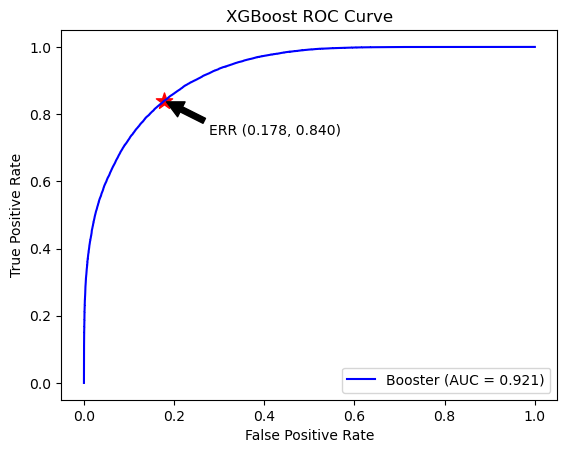

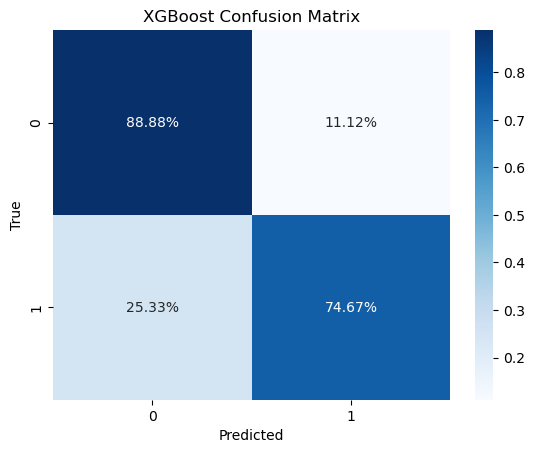

In [139]:
# 绘制XGBoost ROC 曲线
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_model_score)
auc = roc_auc_score(y_cv, y_pred_model_score)
FPR.append(fpr)
TPR.append(tpr)
AUC.append(auc)
plt.plot(fpr,tpr,'b-', label= type(bst).__name__ + ' (AUC = %0.3f)' % auc)
plt.legend()
# 计算 ERR
distance = np.sqrt((1 - tpr)**2 + fpr**2)
err_idx = np.argmin(distance)
plt.scatter(fpr[err_idx], tpr[err_idx], marker='*', s=150, c='r')
plt.annotate('ERR ({:.3f}, {:.3f})'.format(fpr[err_idx], tpr[err_idx]), xy=(fpr[err_idx], tpr[err_idx]), xytext=(fpr[err_idx]+0.1, tpr[err_idx]-0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.title("XGBoost ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# 计算XGBoost混淆矩阵
cm = confusion_matrix(y_cv, y_pred_model, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

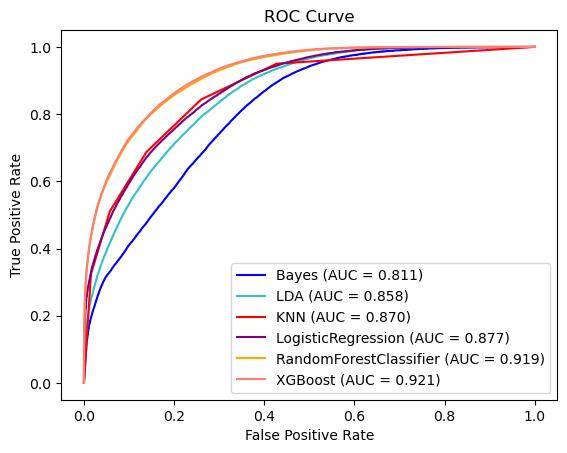

Model Comparison Done!


model              logloss    overall-accuracy  \
0                  GaussianNB  0.33830790046955733  0.7107705398132025   
1  LinearDiscriminantAnalysis   0.2505405478290414  0.7685808136773785   
2        KNeighborsClassifier   0.2927012253862518  0.7968378977362672   
3          LogisticRegression   0.2236476675757937  0.7894075510527149   
4      RandomForestClassifier   0.1785320346162973  0.8343359189488682   
6                     Booster  0.33748441648234107  0.8361761912300143   

                  TPR                 TNR                  FPR  \
0  0.5791884816753927  0.6563173036110107  0.11587618493656758   
1  0.7254028770063755  0.8652591532910975  0.23296285233685998   
2    0.74470176655969  0.8611875304585684  0.18399333448617378   
3  0.7520725550084149   0.874943013000896  0.20955495118768766   
4  0.8006908763679642    0.89206269355929  0.15528760748927073   
6  0.7981117544710346  0.8887299366461775   0.1490308280014463   

                   FNR  
0  0.42081151832460734  
1  0.27459712299362443  
2  0.25529823344030994  
3  0.24792744499158512  
4  0.19930912363203576  
6  0.20188824552896545

In [131]:
# 绘制所有模型的 ROC 曲线
plt.plot(FPR[0],TPR[0],'b-', label='Bayes (AUC = %0.3f)' % AUC[0])
plt.plot(FPR[1],TPR[1],'#35C0CD', label='LDA (AUC = %0.3f)' % AUC[1])
plt.plot(FPR[2],TPR[2],'r-', label='KNN (AUC = %0.3f)' % AUC[2])
plt.plot(FPR[3],TPR[3],'purple', label='LogisticRegression (AUC = %0.3f)' % AUC[3])
plt.plot(FPR[4],TPR[4],'orange', label='RandomForestClassifier (AUC = %0.3f)' % AUC[4])
plt.plot(FPR[5],TPR[5],'#FF7D73', label='XGBoost (AUC = %0.3f)' % AUC[5])
# plt.plot(FPR[6],TPR[6],'#E869AA', label='SVM (AUC = %0.3f)' % AUC[6])
plt.legend()
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print("Model Comparison Done!")

model_comparison

13. K折交叉验证

10 -Fold Cross validation Done!


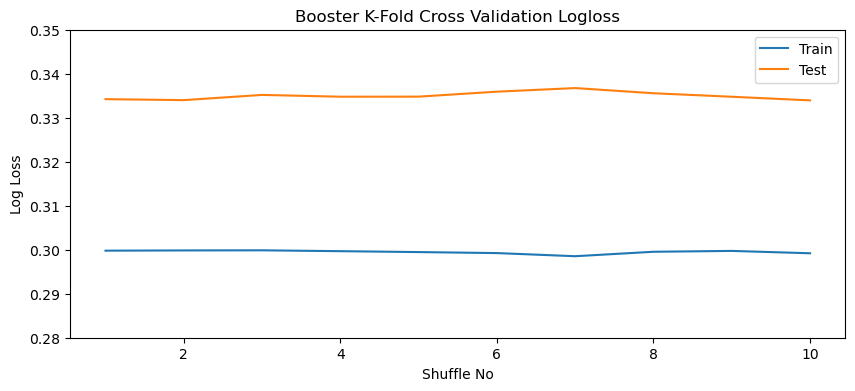

CPU times: total: 93.8 ms
Wall time: 149 ms


In [156]:
%%time

# 导入模型

model = RandomForestClassifier( random_state=0, oob_score=True, n_estimators=300, criterion='gini')     # 随机森林模型
model = LogisticRegression(penalty='l2', solver='liblinear')                                              # 逻辑回归模型
models=[
        # GaussianNB(),                                                                                   # 朴素贝叶斯模型
        # LinearDiscriminantAnalysis(),                                                                   # 线性判别分析模型
        # KNeighborsClassifier(n_neighbors=5),                                                            # KNN 模型
        # LogisticRegression(penalty='l2', solver='liblinear'),                                           # 逻辑回归模型
        RandomForestClassifier( random_state=0, oob_score=True, n_estimators=300, criterion='gini'),    # 随机森林模型
        # SVC(kernel='rbf', gamma=0.1, C=1.0, probability=True)                                           # 支持向量机模型
        ]  

# 定义变量
train_x,test_x,train_y,test_y=[None]*4
num_shuffles=10

shuffled = pickle.load(open('shuffled.pkl', 'rb'))
# 定义保存结果的dataframe
shuffled = pd.DataFrame(columns=['Shuffle No','train_logloss','test_logloss','train_accuracy','test_accuracy','train_recall','test_recall','train_precision','test_precision','train_f1score','test_f1score','train_auc','cv_auc'])


# 开始num_shuffles次随机分组
for i in tqdm(range(num_shuffles)):
    # 随机分组
    train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=None,test_size=0.2,shuffle=True)

    d_train = xgb.DMatrix(train_x, label=train_y)
    d_valid = xgb.DMatrix(test_x, label=test_y)
    d_cv = xgb.DMatrix(train_x)
    d_test = xgb.DMatrix(test_x)
    assert d_train.num_row() == len(train_x)
    assert d_valid.num_row() == len(test_x)
    eval_set = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(params, d_train, num_boost_round=best_iteration, evals=eval_set, evals_result=results, early_stopping_rounds=early_stopping_rounds, verbose_eval=10)
    # model.fit(train_x,train_y)
    # 在训练集上预测结果，并计算准确率
    # y_pred = model.predict(train_x)
    y_train_score = model.predict(d_cv)
    y_train = [1 if x > 0.5 else 0 for x in y_train_score]
    accuracy_train = sum([y_train==train_y][0].values)/len(train_y)
    # 计算训练集的召回率、精确率、F1分数和AUC
    tr_precision = precision_score(train_y, y_train)
    tr_recall = recall_score(train_y, y_train)
    tr_f1score = f1_score(train_y, y_train)
    tr_auc = roc_auc_score(train_y, y_train)

    # 计算训练集的召回率、精确率、F1分数和AUC
    # y_pred = model.predict(test_x)
    y_pred_score = model.predict(d_test)
    y_pred = [1 if x > 0.5 else 0 for x in y_pred_score]
    accuracy_cv = sum([y_pred==test_y][0].values)/len(test_y)
    # 计算训练集的召回率、精确率、F1分数和AUC
    cv_precision = precision_score(test_y, y_pred)
    cv_recall = recall_score(test_y, y_pred)
    cv_f1score = f1_score(test_y, y_pred)
    cv_auc = roc_auc_score(test_y, y_pred)
    
    # 计算训练集和测试集的logloss
    # train_logloss = log_loss(model.predict(train_x), train_y)
    # test_logloss = log_loss(model.predict(test_x), test_y)
    train_logloss = log_loss(d_train.get_label(), y_train_score)
    test_logloss = log_loss(d_valid.get_label(), y_pred_score)

    # 将结果保存到dataframe中
    shuffled.loc[len(shuffled.index)]=[int(i+1), train_logloss ,test_logloss,  accuracy_train, accuracy_cv, tr_recall, cv_recall, tr_precision, cv_precision, tr_f1score, cv_f1score, tr_auc, cv_auc]

# 显示结果
shuffled.head(5)
print(num_shuffles,"-Fold Cross validation Done!")

# 可视化训练集和测试集的logloss
fig = plt.figure(figsize=(10, 4))
plt.plot(shuffled['Shuffle No'], shuffled['train_logloss'], label='Train')
plt.plot(shuffled['Shuffle No'], shuffled['test_logloss'], label='Test')
plt.legend()
plt.title(type(model).__name__ + " K-Fold Cross Validation Logloss")
plt.xlabel('Shuffle No')
plt.ylabel('Log Loss')
plt.ylim(0.28, 0.35)
plt.show()

In [152]:
# import pickle

# with open('shuffled.pkl', 'wb') as f:
#     pickle.dump(shuffled, f)

14. 测试数据导入

In [ ]:
df_test =  pd.read_csv('./dataset/quora-question-pairs/test.csv')
print(df_test.shape)
print("Test Data imported")
df_test.head(2)

(2345796, 3)
Test Data imported


test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?

In [ ]:
df_test.isna().sum()  # 计算每列缺失值的数量

test_id      0
question1    2
question2    4
dtype: int64

15. 测试数据集中缺少值

In [ ]:
df_test.loc[df_test.isnull().any(axis=1),:]

test_id                                    question1  \
379205    379205     How I can learn android app development?   
817520    817520  How real can learn android app development?   
943911    943911                         How app development?   
1046690  1046690                                          NaN   
1270024  1270024             How I can learn app development?   
1461432  1461432                                          NaN   

                                               question2  
379205                                               NaN  
817520                                               NaN  
943911                                               NaN  
1046690    How I what can learn android app development?  
1270024                                              NaN  
1461432  How distinct can learn android app development?

In [ ]:
df_test = df_test.fillna("Unknown")     # 将缺失值用unkown代替
df_test.isna().sum(), df_test.shape

(test_id      0
 question1    0
 question2    0
 dtype: int64,
 (2345796, 3))

15. 测试集中独特和重复问题的分析

In [ ]:
dff = df_test.copy()
dff.loc[:,'question1'] = dff.loc[:,'question1'].str.strip()
dff.loc[:,'question2'] = dff.loc[:,'question2'].str.strip()
questions_list = pd.concat([dff['question1'] , dff['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in Test dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  4208103
Number of Questions which are repeated:  155665
Total number of unique questions in Test dataset:  4363768


16. 测试数据：文本预处理

In [ ]:
%%time
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    contractions = { 
    "ain't": "am not",     "aren't": "are not",         "can't": "can not",         "can't've": "can not have",
    "'cause": "because",   "could've": "could have",    "couldn't": "could not",    "couldn't've": "could not have",
    "didn't": "did not",   "doesn't": "does not",       "don't": "do not",          "hadn't": "had not",
    "hadn't've": "had not have",    "hasn't": "has not","haven't": "have not",      "he'd": "he would",
    "he'd've": "he would have",     "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did",    "how'd'y": "how do you",     "how'll": "how will",       "how's": "how is",
    "i'd": "i would",      "i'd've": "i would have",    "i'll": "i will",           "i'll've": "i will have",
    "i'm": "i am",         "i've": "i have",            "isn't": "is not",          "it'd": "it would",
    "it'd've": "it would have",     "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us",     "ma'am": "madam",            "mayn't": "may not",        "might've": "might have",
    "mightn't": "might not",        "mightn't've": "might not have",                "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",  "needn't": "need not",   "needn't've": "need not have",
    "o'clock": "of the clock",    "oughtn't": "ought not", "oughtn't've": "ought not have","shan't": "shall not",
    "sha'n't": "shall not","shan't've": "shall not have",  "she'd": "she would",    "she'd've": "she would have",
    "she'll": "she will",  "she'll've": "she will have",   "she's": "she is",       "should've": "should have",
    "shouldn't": "should not","shouldn't've": "should not have","so've": "so have", "so's": "so as",
    "that'd": "that would","that'd've": "that would have", "that's": "that is",     "there'd": "there would",
    "there'd've": "there would have","there's": "there is","they'd": "they would",  "they'd've": "they would have",
    "they'll": "they will","they'll've": "they will have", "they're": "they are",
    "they've": "they have","to've": "to have",    "wasn't": "was not",    "we'd": "we would","we'd've": "we would have",
    "we'll": "we will",    "we'll've": "we will have",    "we're": "we are","we've": "we have","weren't": "were not",
    "what'll": "what will",    "what'll've": "what will have",    "what're": "what are",    "what's": "what is",
    "what've": "what have",    "when's": "when is",    "when've": "when have",    "where'd": "where did",
    "where's": "where is",    "where've": "where have",    "who'll": "who will",    "who'll've": "who will have",
    "who's": "who is",    "who've": "who have",    "why's": "why is",    "why've": "why have",    "will've": "will have",
    "won't": "will not",    "won't've": "will not have",    "would've": "would have",    "wouldn't": "would not",
    "wouldn't've": "would not have",    "y'all": "you all",    "y'all'd": "you all would",    "y'all'd've": "you all would have",
    "y'all're": "you all are",    "y'all've": "you all have",    "you'd": "you would",    "you'd've": "you would have",
    "you'll": "you will",    "you'll've": "you will have",    "you're": "you are",    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

dff['question1'] = dff['question1'].apply(preprocess)
dff['question2'] = dff['question2'].apply(preprocess)

dff = pickle.load(open('dff1.pkl', 'rb'))
print("Test Data Pre-Processing Done!")

Test Data Pre-Processing Done!
CPU times: total: 656 ms
Wall time: 764 ms


In [ ]:
# import pickle

# with open('dff1.pkl', 'wb') as f:
#     pickle.dump(dff, f)

17. 问题聚类

In [ ]:
%%time
test_document_corpus = list(set(list(dff['question1']) + list(dff['question2'])))
test_questions_cluster = pd.DataFrame({'questions': test_document_corpus , 'cluster_label':None})
x = vectorizer.fit_transform(test_questions_cluster['questions'].values)
vectorizer = TfidfVectorizer()
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
test_questions_cluster['cluster_label'] = km.labels_
test_questions_cluster = pickle.load(open('test_questions_cluster.pkl', 'rb'))
test_questions_cluster.head(3)

CPU times: total: 578 ms
Wall time: 668 ms


questions  cluster_label
0                                                                 2
1                  how management i pass an etg test              4
2  can we  use one seat out of 3 booked seats on ...              7

In [ ]:
# import pickle

# # 保存聚类模型
# with open('test_questions_cluster.pkl', 'wb') as f:
#     pickle.dump(test_questions_cluster, f)

In [ ]:
# 将聚类得到的结果合并到原始数据中
dff = pd.merge( left=pd.merge(left=dff, right=test_questions_cluster, left_on="question1", right_on="questions"), right=test_questions_cluster , left_on="question2", right_on="questions")
dff.drop(["questions_x","questions_y"], axis=1, inplace=True)
dff.rename(columns={'cluster_label_x':'q1_cluster','cluster_label_y':'q2_cluster'}, inplace=True)
print("Test Questions Clusters Labelled")
dff.head(4)

Test Questions Clusters Labelled


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   
2        2  what but is the best way to send money from ch...   
3        3                         which food not emulsifiers   

                                           question2  q1_cluster  q2_cluster  
0  why did microsoft choose core m3 and not core ...           4           8  
1         how much cost does hair transplant require           4           4  
2                       what you send money to china           5           3  
3                                   what foods fibre           1           2

In [ ]:
dff.columns

Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster'], dtype='object')

18. 基本文本特征工程

In [ ]:
%%time
from fuzzywuzzy import fuzz
import sys

dff = pd.merge( pd.merge(dff,pd.DataFrame({'question1':dff['question1'].value_counts().index.values,'freq_qid1':dff['question1'].value_counts().values}), on='question1',how="left"),pd.DataFrame({'question2':dff['question2'].value_counts().index.values,'freq_qid2':dff['question2'].value_counts().values}) ,on='question2', how='left')
dff.loc[:,['q1_length']] = dff['question1'].apply(lambda x: len(x)).values
dff.loc[:,['q2_length']] = dff['question2'].apply(lambda x: len(x)).values
dff['same_cluster'] = dff[['q1_cluster','q2_cluster']].apply(lambda x: 1 if x[0]==x[1] else 0, axis=1)
dff['q1_wordsCount'] = dff['question1'].apply(lambda x: len(x.split(" ")))
dff['q2_wordsCount'] = dff['question2'].apply(lambda x: len(x.split(" ")))
dff['common_wordsCount'] = dff[['question1','question2']].apply(lambda x: len(set(x[0].split(" ")).intersection(set(x[1].split(" ")))) , axis=1 )
dff['q1_freq+q2_freq'] = dff['freq_qid1']+dff['freq_qid2']
dff['q1_freq-q2_freq'] = abs(dff['freq_qid1']-dff['freq_qid2'])
dff['total_word_share'] = 2*dff['common_wordsCount']/(dff['q1_wordsCount']+dff['q2_wordsCount'])

dff = pickle.load(open('dff2.pkl', 'rb'))
print("Test Basic Feature Engineering Done!")
dff.head(2)

Test Basic Feature Engineering Done!
CPU times: total: 625 ms
Wall time: 869 ms


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           4           8   
1         how much cost does hair transplant require           4           4   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  q1_wordsCount  \
0          1          1         56         67             0             11   
1          1          1         65         42             1             15   

   q2_wordsCount  common_wordsCount  q1_freq+q2_freq  q1_freq-q2_freq  \
0             14                  3                2                0   
1              7                  5                2                0   

   total_word_share  
0          0.240000  
1          0.454545

In [ ]:
# import pickle

# with open('dff2.pkl', 'wb') as f:
#     pickle.dump(dff, f)

19. 测试数据中的高级文本特征工程

In [ ]:
%%time
import distance

STOP_WORDS = stopwords.words("english")
epsilon = 0.001
       
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def advanced_featureExtract(q1,q2):
    
    q1_tokens = q1.split(" ")
    q2_tokens = q2.split(" ")
    
    q1_stopwords = [word for word in q1_tokens if word in STOP_WORDS]
    q2_stopwords = [word for word in q2_tokens if word in STOP_WORDS]
    
    q1_words = [word for word in q1_tokens if word not in STOP_WORDS]
    q2_words = [word for word in q2_tokens if word not in STOP_WORDS]
        
    common_words = list(set(q1_words).intersection(set(q2_words)))
    common_stopwords = list(set(q1_stopwords).intersection(set(q2_stopwords)))
    common_tokens = list(set(q1_tokens).intersection(set(q2_tokens)))
    
    com_words_count_min = len(common_words)/(epsilon + min(len(q2_words), len(q1_words)) )
    com_words_count_max = len(common_words)/(epsilon + max(len(q2_words), len(q1_words)) )
    
    com_stopwords_count_min = len(common_words)/(epsilon + min(len(q2_stopwords), len(q1_stopwords)) )
    com_stopwords_count_max = len(common_stopwords)/(epsilon + max(len(q2_stopwords), len(q1_stopwords)) )
    
    com_token_count_min = len(common_tokens)/(epsilon + min(len(q2_tokens), len(q1_tokens)) )
    com_token_count_max = len(common_tokens)/(epsilon + max(len(q2_tokens), len(q1_tokens)) )
    
    last_word_eq  = 1 if q2_tokens[-1] == q1_tokens[-1] else 0
    first_word_eq = 1 if q2_tokens[0]  == q1_tokens[0]  else 0
    
    abs_len_diff = abs(len(q2_tokens) - len(q1_tokens))
    mean_len = (len(q2_tokens) + len(q1_tokens))/2
    
    longest_substring_ratio = get_longest_substr_ratio(q1, q2)
    
    return com_words_count_min, com_words_count_max, com_stopwords_count_min,  com_stopwords_count_max, com_token_count_min, com_token_count_max,  last_word_eq, first_word_eq, abs_len_diff, mean_len, longest_substring_ratio
       
token_features = dff.apply(lambda x: advanced_featureExtract(x["question1"], x["question2"]), axis=1)

dff["cwc_min"]       = list(map(lambda x: x[0], token_features))
dff["cwc_max"]       = list(map(lambda x: x[1], token_features))
dff["csc_min"]       = list(map(lambda x: x[2], token_features))
dff["csc_max"]       = list(map(lambda x: x[3], token_features))
dff["ctc_min"]       = list(map(lambda x: x[4], token_features))
dff["ctc_max"]       = list(map(lambda x: x[5], token_features))
dff["last_word_eq"]  = list(map(lambda x: x[6], token_features))
dff["first_word_eq"] = list(map(lambda x: x[7], token_features))
dff["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
dff["mean_len"]      = list(map(lambda x: x[9], token_features))
dff["longest_substring_ratio"] = list(map(lambda x: x[10], token_features))

dff = pickle.load(open('dff3.pkl', 'rb'))
print("Test Data Advanced Feature Engineering Done!")
dff.head(2)

Test Data Advanced Feature Engineering Done!
CPU times: total: 766 ms
Wall time: 1.03 s


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           4           8   
1         how much cost does hair transplant require           4           4   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  ...   cwc_max  \
0          1          1         56         67             0  ...  0.299970   
1          1          1         65         42             1  ...  0.499938   

    csc_min   csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
0  0.749813  0.000000  0.272702  0.214270             0              0   
1  1.999000  0.142837  0.714184  0.333311             0              0   

   abs_len_diff  mean_len  longest_substring_ratio  
0             3      12.5                 0.245614  
1             8      11.0                 0.395349  

[2 rows x 27 columns]

In [ ]:
# import pickle

# with open('dff3.pkl', 'wb') as f:
#     pickle.dump(dff, f)

In [ ]:
dff.columns

Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster',
       'freq_qid1', 'freq_qid2', 'q1_length', 'q2_length', 'same_cluster',
       'q1_wordsCount', 'q2_wordsCount', 'common_wordsCount',
       'q1_freq+q2_freq', 'q1_freq-q2_freq', 'total_word_share', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substring_ratio'],
      dtype='object')

20. 从测试数据中提取的模糊文本相似度

In [ ]:
%%time
dff['fuzz_ratio']           = dff[['question1','question2']].apply(lambda x: fuzz.ratio(           x[0],x[1]), axis=1)
dff['fuzz_partial_ratio']   = dff[['question1','question2']].apply(lambda x: fuzz.partial_ratio(   x[0],x[1]), axis=1)
dff['fuzz_token_sort_ratio']= dff[['question1','question2']].apply(lambda x: fuzz.token_sort_ratio(x[0],x[1]), axis=1)
dff['fuzz_token_set_ratio'] = dff[['question1','question2']].apply(lambda x: fuzz.token_set_ratio( x[0],x[1]), axis=1)
dff['fuzz_WRatio']          = dff[['question1','question2']].apply(lambda x: fuzz.WRatio(          x[0],x[1]), axis=1)

dff = pickle.load(open('dff4.pkl', 'rb'))
print("Test Fuzzy Ratios Done!")
dff.head(2) 

Test Fuzzy Ratios Done!
CPU times: total: 812 ms
Wall time: 1.17 s


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           4           8   
1         how much cost does hair transplant require           4           4   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  ...  \
0          1          1         56         67             0  ...   
1          1          1         65         42             1  ...   

   last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0             0              0             3      12.5   
1             0              0             8      11.0   

   longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
0                 0.245614          46                  45   
1                 0.395349          49                  57   

   fuzz_token_sort_ratio  fuzz_token_set_ratio  fuzz_WRatio  
0                     55                    58           55  
1                     58                    82           86  

[2 rows x 32 columns]

In [ ]:
# import pickle

# with open('dff4.pkl', 'wb') as f:
#     pickle.dump(dff, f)

21. 为测试数据提取余弦相似性

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

document_corpus = list(dff['question1'])+list(dff['question2'])
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(document_corpus)
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

dff['cosine_similarity'] = ques_pair_vectors
dff = pickle.load(open('dff5.pkl', 'rb'))
print("Test Data Cosine Similarity Extracted!")
print("Columns: ",dff.columns)
dff.head(2)

Test Data Cosine Similarity Extracted!
Columns:  Index(['test_id', 'question1', 'question2', 'q1_cluster', 'q2_cluster',
       'freq_qid1', 'freq_qid2', 'q1_length', 'q2_length', 'same_cluster',
       'q1_wordsCount', 'q2_wordsCount', 'common_wordsCount',
       'q1_freq+q2_freq', 'q1_freq-q2_freq', 'total_word_share', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substring_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'fuzz_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_WRatio', 'cosine_similarity'],
      dtype='object')
CPU times: total: 2.06 s
Wall time: 2.64 s


test_id                                          question1  \
0        0  how does the surface pro himself 4 compare wit...   
1        1  should i have a hair transplant at age 24  how...   

                                           question2  q1_cluster  q2_cluster  \
0  why did microsoft choose core m3 and not core ...           4           8   
1         how much cost does hair transplant require           4           4   

   freq_qid1  freq_qid2  q1_length  q2_length  same_cluster  ...  \
0          1          1         56         67             0  ...   
1          1          1         65         42             1  ...   

   first_word_eq  abs_len_diff  mean_len  longest_substring_ratio  fuzz_ratio  \
0              0             3      12.5                 0.245614          46   
1              0             8      11.0                 0.395349          49   

   fuzz_partial_ratio  fuzz_token_sort_ratio  fuzz_token_set_ratio  \
0                  45                     55                    58   
1                  57                     58                    82   

   fuzz_WRatio  cosine_similarity  
0           55           0.288652  
1           86           0.595792  

[2 rows x 33 columns]

In [ ]:
# import pickle

# with open('dff5.pkl', 'wb') as f:
#     pickle.dump(dff, f)

22. 测试集和提交预测

In [ ]:
x= df.copy()
x.drop(['id','qid1','qid2','question1','question2','is_duplicate','q1_cluster', 'q2_cluster'], axis=1, inplace=True)
sc_x = StandardScaler()
x.insert(loc=0, column='x0', value=[1]*len(x))
x.iloc[:,1:-1] = sc_x.fit_transform(x.iloc[:,1:-1])
y=df['is_duplicate'].apply(lambda x: 0 if x=="No" else 1)


model = pickle.load(open('xgb.pkl', 'rb'))
y_pred = model.predict(xgb.DMatrix(x))
# print("Logloss of XGBoost Model: ", log_loss(y_pred, y))

In [ ]:
from sklearn.preprocessing import StandardScaler


xx= dff.copy()
xx.drop(['test_id','question1','question2','q1_cluster', 'q2_cluster'], axis=1, inplace=True)
sc_x = StandardScaler()
xx.insert(loc=0, column='x0', value=[1]*len(xx))
xx.iloc[:,1:-1] = sc_x.fit_transform(xx.iloc[:,1:-1])

xx = pickle.load(open('xx.pkl', 'rb'))
Dx = xgb.DMatrix(xx)
prob = model.predict(Dx)
print("Prediction Test Data Done!")

Prediction Test Data Done!


In [ ]:
# import pickle

# with open('xx.pkl', 'wb') as f:
#     pickle.dump(xx, f)

In [ ]:
dff['is_duplicate']=pd.DataFrame(prob).iloc[:,0].values

sub = pd.DataFrame()
sub['test_id'] = dff['test_id']
sub['is_duplicate'] = prob
sub.to_csv('submission.csv', index=False)

# submission = dff.loc[:, ['test_id', 'is_duplicate']].copy()
# submission.to_csv('submission.csv', index=False)

print("Submission File printed !")

Submission File printed !


NameError: name 'submission' is not defined